# Data Analytics Framework for Fire Severity

In [2]:
!jupyter nbextension enable toc2/main

Enabling notebook extension toc2/main...
      - Validating: OK


#### Project Understanding 
##### Recent fires from 2020 have brought up various concerns from the health implications to possible understanding / prevention that can carried out by understanding characteristics of the fire. Therefore, this jupyter notebook puts together a framework for others to understand the current database and provide framework to run analysis on new attributes

#### Data Understanding
* CALIFREPORTINGDB_H2O 
* MASTER021920 (MASTER, join by CARDBRECID - California Reporting DB ID, BPS140, EVT140, EVT130, EVT120, EVT110, EVT105, LEMMA_CODE, MGMTSCAP_V, HUC12)
* BURNSEVERITY2020 (TARGET - Severity 1-4, join by CARDBRECID)  
* FROM landfire.gov/version_comparison.php 
* CA_BPS140 (ATTRIBUTE - Biophsical Setting, join by BPS140) 
* CA_EVT110 (ATTRIBUTE - Existing Vegtation Type - 2008, join by VALUE)
* CA_EVT120 (ATTRIBUTE - Existing Vegtation Type - 2010, join by VALUE)
* CA_EVT130 (ATTRIBUTE - Existing Vegtation Type - 2012, join by VALUE)
* CA_EVT140 (ATTRIBUTE - Existing Vegtation Type - 2014, join by VALUE)
* CENSUS_BLK_PLACE_INCORP #### ELEV (ATTRIBUTE, join by CARDBRECID)
* GEO_LAT_LON (ATTRIBUTE, join by CARDBRECID)
* SALO_BD_ADAM_TEST (ATTRIBUTE, join by CARDBRECID)
* TUBBSING_TREE_MORTALITY (ATTRIBUTE, join by CARDBRECID)

#### Data Preparation
##### Load needed packages

In [3]:
from arcgis.gis import GIS
gis = GIS("home")

# Note: install snowflake connector for python - special version for ArcGIS online
! pip install snowflake-connector-python[pandas]

! pip install mord
! pip install graphviz
! pip install pydotplus
! pip install pydot
# for Spearmans
!pip install scipy==1.2.3 #https://github.com/CSTR-Edinburgh/merlin/issues/470

# No need to install pyarrow for ArcGIS online
# ! pip install pyarrow==0.17.0

import time

import arcpy
from arcgis.features import SpatialDataFrame
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import pandas as pd
import pyarrow

import snowflake.connector
from snowflake.connector import DictCursor
from snowflake.connector.pandas_tools import write_pandas

import getpass
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.transforms

import numpy as np
import scipy.stats

     |████████████████████████████████| 13.2 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 59.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 58.7 MB/s eta 0:00:01
     |████████████████████████████████| 192 kB 58.2 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 59.1 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 66.6 MB/s eta 0:00:01
     |████████████████████████████████| 20.7 MB 32.2 MB/s eta 0:00:01     |█████████████████               | 11.0 MB 32.2 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 3.2 MB/s  eta 0:00:01
     |████████████████████████████████| 133 kB 69.8 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 3.8 MB/s  eta 0:00:01
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages

  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.2
    Uninstalling scipy-1.5.2:
      Successfully uninstalled scipy-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
tensorflow 2.2.0 requires scipy==1.4.1; python_version >= "3", but you have scipy 1.2.3 which is incompatible.
tensorflow 2.2.0 requires tensorboard<2.3.0,>=2.2.0, but you have tensorboard 2.3.0 which is incompatible.


/opt/conda/lib/python3.7/site-packages/snowflake/connector/vendored/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


#### Connect to Snowflake

In [4]:
ctx = snowflake.connector.connect(
    user='filipiyada7',
    password=getpass.getpass('password: '),
    account='dva61212',
    warehouse='COMPUTE_WH',
    database='CALIFREPORTINGDB_H20',
    schema='PUBLIC',
    protocol='https'
)
cur = ctx.cursor()

password: ········


In [5]:
# ### Create Snowflake Datawarehousing Table 

# USE DATABASE CALIFREPORTINGDB_H2O;
# CREATE TABLE DEMO_DB.PUBLIC.DW_SEVERITY AS
# (SELECT M.CARDBRECID, BURN.BURNSEVERITY2020BA4, M.LEMMA_CODE, GEO.LON, GEO.LAT, GEO.GEO_SHP, EVT140.EVT_FUEL_N,E.SLOPE, E.ELEV_M, E.ASPECT, 'Creek'AS FIRE_NAME
# FROM public.MASTER021920 AS M 
# JOIN public.BURNSEVERITY2020 AS BURN ON BURN.CARDBRECID = M.CARDBRECID
# JOIN public.GEO_LAT_LON AS GEO ON GEO.CARDBRECID = M.CARDBRECID
# JOIN public.CA_EVT140 AS EVT140 ON EVT140.VALUE = M.EVT140
# JOIN public.ELEV AS E ON E.CARDBRECID = M.CARDBRECID
# JOIN public.TUBBSING_TREE_MORTALITY TM on TM.CARDBRECID = BURN.CARDBRECID
# WHERE BURN.BURNSEVERITY2020BA4 <=4
# AND LON BETWEEN -119.63 AND -118.79
# AND LAT BETWEEN 36.93 AND 37.718
# UNION 
# SELECT M.CARDBRECID, BURN.BURNSEVERITY2020BA4, M.LEMMA_CODE, GEO.LON, GEO.LAT, GEO.GEO_SHP, EVT140.EVT_FUEL_N,E.SLOPE, E.ELEV_M, E.ASPECT, 'Claremont-Bear'AS FIRE_NAME
# FROM public.MASTER021920 AS M 
# JOIN public.BURNSEVERITY2020 AS BURN ON BURN.CARDBRECID = M.CARDBRECID
# JOIN public.GEO_LAT_LON AS GEO ON GEO.CARDBRECID = M.CARDBRECID
# JOIN public.CA_EVT140 AS EVT140 ON EVT140.VALUE = M.EVT140
# JOIN public.ELEV AS E ON E.CARDBRECID = M.CARDBRECID
# JOIN public.TUBBSING_TREE_MORTALITY TM on TM.CARDBRECID = BURN.CARDBRECID
# WHERE BURN.BURNSEVERITY2020BA4 <=4
# AND LON BETWEEN -121.336 AND -120.74
# AND LAT BETWEEN 39.522 AND 39.91
# UNION 
# SELECT M.CARDBRECID, BURN.BURNSEVERITY2020BA4, M.LEMMA_CODE, GEO.LON, GEO.LAT, GEO.GEO_SHP, EVT140.EVT_FUEL_N,E.SLOPE, E.ELEV_M, E.ASPECT,  'Castle'AS FIRE_NAME
# FROM public.MASTER021920 AS M 
# JOIN public.BURNSEVERITY2020 AS BURN ON BURN.CARDBRECID = M.CARDBRECID
# JOIN public.GEO_LAT_LON AS GEO ON GEO.CARDBRECID = M.CARDBRECID
# JOIN public.CA_EVT140 AS EVT140 ON EVT140.VALUE = M.EVT140
# JOIN public.ELEV AS E ON E.CARDBRECID = M.CARDBRECID
# JOIN public.TUBBSING_TREE_MORTALITY TM on TM.CARDBRECID = BURN.CARDBRECID
# WHERE BURN.BURNSEVERITY2020BA4 <=4
# AND LON BETWEEN -118.85 AND -118.298
# AND LAT BETWEEN 36.10 AND 36.397);
# """


In [6]:
# May need to run depending on which role you authorized the database under
query = 'USE ROLE ACCOUNTADMIN'
cur.execute(query)

In [8]:
query = 'USE DATABASE DEMO_DB'
cur.execute(query)

In [9]:
query = 'SELECT * FROM PUBLIC.FIRE_SEVERITY'

cur.execute(query)
df = cur.fetch_pandas_all()

In [10]:
df

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,GEO_SHP,EVT_FUEL_N,SLOPE,ELEV_M,ASPECT,FIRE_NAME
0,226128814,1,102331,-119.02248,37.14730,"{\n ""coordinates"": [\n -1.190224800000000e...",Tr Mediterranean California Red Fir Forest,12,2654,67,Creek
1,226611477,4,129968,-119.02277,37.13704,"{\n ""coordinates"": [\n -1.190227700000000e...",Tr Mediterranean California Red Fir Forest,7,2649,98,Creek
2,227960628,2,129968,-119.01832,37.10950,"{\n ""coordinates"": [\n -1.190183200000000e...",Tr Mediterranean California Red Fir Forest,12,2657,130,Creek
3,226233072,1,102378,-119.01918,37.14573,"{\n ""coordinates"": [\n -1.190191800000000e...",Tr Mediterranean California Red Fir Forest,7,2635,57,Creek
4,226951316,2,147985,-119.03024,37.12842,"{\n ""coordinates"": [\n -1.190302400000000e...",Tr Sierra Nevada Subalpine Lodgepole Pine Fore...,6,2759,22,Creek
...,...,...,...,...,...,...,...,...,...,...,...
3536074,284171931,4,147671,-118.44985,36.10419,"{\n ""coordinates"": [\n -1.184498500000000e...",He Inter-Mountain Basins Semi-Desert Grassland,27,1761,273,Castle
3536075,284200673,4,68370,-118.43171,36.10711,"{\n ""coordinates"": [\n -1.184317100000000e...",Tr Mediterranean California Mesic Mixed Conife...,31,1967,26,Castle
3536076,284214995,1,84581,-118.43883,36.10547,"{\n ""coordinates"": [\n -1.184388300000000e...",Tr Mediterranean California Mesic Mixed Conife...,21,1790,308,Castle
3536077,284229346,2,132286,-118.43679,36.10559,"{\n ""coordinates"": [\n -1.184367900000000e...",Tr Mediterranean California Mixed Oak Woodland,35,1875,312,Castle


In [11]:
query = "SELECT * FROM PUBLIC.FIRE_SEVERITY WHERE FIRE_NAME = 'Castle'"

cur.execute(query)
df_castle = cur.fetch_pandas_all()

In [12]:
df_castle

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,GEO_SHP,EVT_FUEL_N,SLOPE,ELEV_M,ASPECT,FIRE_NAME
0,283498198,3,-151,-118.51076,36.10544,"{\n ""coordinates"": [\n -1.185107600000000e...",Sh California Montane Woodland and Chaparral,11,2267,135,Castle
1,283512584,4,68191,-118.48878,36.10939,"{\n ""coordinates"": [\n -1.184887800000000e...",Tr California Montane Jeffrey Pine(-Ponderosa ...,25,2366,138,Castle
2,283627069,4,133482,-118.51724,36.10171,"{\n ""coordinates"": [\n -1.185172400000000e...",Tr Mediterranean California Mesic Mixed Conife...,13,2221,295,Castle
3,283641495,3,-132,-118.48382,36.10786,"{\n ""coordinates"": [\n -1.184838200000000e...",Sps Inter-Mountain Basins Sparsely Vegetated S...,48,2356,128,Castle
4,283842059,3,128151,-118.48958,36.10290,"{\n ""coordinates"": [\n -1.184895800000000e...",Tr Mediterranean California Mixed Oak Woodland,22,2007,176,Castle
...,...,...,...,...,...,...,...,...,...,...,...
760839,268348884,3,-132,-118.67563,36.36554,"{\n ""coordinates"": [\n -1.186756300000000e...",Sh California Montane Woodland and Chaparral,10,2694,172,Castle
760840,268405351,1,106350,-118.69892,36.35994,"{\n ""coordinates"": [\n -1.186989200000000e...",Tr Mediterranean California Mesic Mixed Conife...,25,1900,5,Castle
760841,268490166,2,132477,-118.69942,36.35818,"{\n ""coordinates"": [\n -1.186994200000000e...",Tr Mediterranean California Mesic Mixed Conife...,28,2016,340,Castle
760842,268574984,1,127525,-118.70222,36.35599,"{\n ""coordinates"": [\n -1.187022200000000e...",Tr Mediterranean California Mesic Mixed Conife...,29,2068,349,Castle


In [13]:
query ="SELECT * FROM PUBLIC.FIRE_SEVERITY WHERE FIRE_NAME = 'Claremont-Bear'"

cur.execute(query)
df_claremont = cur.fetch_pandas_all()

In [14]:
df_claremont

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,GEO_SHP,EVT_FUEL_N,SLOPE,ELEV_M,ASPECT,FIRE_NAME
0,106591502,4,87009,-121.27893,39.72470,"{\n ""coordinates"": [\n -1.212789300000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,15,1138,161,Claremont-Bear
1,106613987,4,139996,-121.30906,39.71791,"{\n ""coordinates"": [\n -1.213090600000000e...",Tr Mediterranean California Mesic Mixed Conife...,13,1100,354,Claremont-Bear
2,106614007,4,104365,-121.30225,39.71932,"{\n ""coordinates"": [\n -1.213022500000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,31,900,45,Claremont-Bear
3,106614133,4,101222,-121.25932,39.72819,"{\n ""coordinates"": [\n -1.212593200000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,35,904,121,Claremont-Bear
4,106614140,4,75134,-121.25693,39.72868,"{\n ""coordinates"": [\n -1.212569300000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,39,877,210,Claremont-Bear
...,...,...,...,...,...,...,...,...,...,...,...
1108716,107369234,3,98911,-121.30148,39.70089,"{\n ""coordinates"": [\n -1.213014800000000e...",Tr California Montane Riparian Systems,8,1149,328,Claremont-Bear
1108717,107448161,4,104365,-121.25518,39.70851,"{\n ""coordinates"": [\n -1.212551800000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,36,694,245,Claremont-Bear
1108718,107526921,4,72495,-121.25862,39.70586,"{\n ""coordinates"": [\n -1.212586200000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,30,703,350,Claremont-Bear
1108719,107560666,4,101919,-121.26072,39.70459,"{\n ""coordinates"": [\n -1.212607200000000e...",Tr Mediterranean California Dry-Mesic Mixed Co...,34,715,350,Claremont-Bear


In [15]:
query = " SELECT * FROM PUBLIC.FIRE_SEVERITY WHERE FIRE_NAME = 'Creek' "

cur.execute(query)
df_creek = cur.fetch_pandas_all()

In [16]:
df_creek

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,GEO_SHP,EVT_FUEL_N,SLOPE,ELEV_M,ASPECT,FIRE_NAME
0,226128814,1,102331,-119.02248,37.14730,"{\n ""coordinates"": [\n -1.190224800000000e...",Tr Mediterranean California Red Fir Forest,12,2654,67,Creek
1,226611477,4,129968,-119.02277,37.13704,"{\n ""coordinates"": [\n -1.190227700000000e...",Tr Mediterranean California Red Fir Forest,7,2649,98,Creek
2,227960628,2,129968,-119.01832,37.10950,"{\n ""coordinates"": [\n -1.190183200000000e...",Tr Mediterranean California Red Fir Forest,12,2657,130,Creek
3,226233072,1,102378,-119.01918,37.14573,"{\n ""coordinates"": [\n -1.190191800000000e...",Tr Mediterranean California Red Fir Forest,7,2635,57,Creek
4,226951316,2,147985,-119.03024,37.12842,"{\n ""coordinates"": [\n -1.190302400000000e...",Tr Sierra Nevada Subalpine Lodgepole Pine Fore...,6,2759,22,Creek
...,...,...,...,...,...,...,...,...,...,...,...
1666509,203152891,4,85874,-119.23139,37.62250,"{\n ""coordinates"": [\n -1.192313900000000e...",Sh California Montane Woodland and Chaparral,18,2274,228,Creek
1666510,203296576,3,78152,-119.23172,37.61913,"{\n ""coordinates"": [\n -1.192317200000000e...",Tr Mediterranean California Mesic Mixed Conife...,12,2197,208,Creek
1666511,203308564,4,78152,-119.22698,37.61977,"{\n ""coordinates"": [\n -1.192269800000000e...",Tr Mediterranean California Mesic Mixed Conife...,17,2139,172,Creek
1666512,203320512,4,68119,-119.23588,37.61776,"{\n ""coordinates"": [\n -1.192358800000000e...",Sh California Montane Woodland and Chaparral,32,2284,148,Creek


In [17]:
df.describe()

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
count,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06,3.536079e+06
mean,1.947901e+08,2.879853e+00,9.985694e+04,-1.197058e+02,3.784733e+01,1.754489e+01,1.687319e+03,1.865626e+02
std,6.411320e+07,1.217569e+00,3.450692e+04,1.021938e+00,1.354855e+00,9.873920e+00,5.116336e+02,1.013470e+02
min,9.858018e+07,1.000000e+00,-2.860000e+02,-1.213360e+02,3.610000e+01,0.000000e+00,2.640000e+02,-1.000000e+00
25%,1.102513e+08,2.000000e+00,7.777300e+04,-1.210294e+02,3.710752e+01,1.000000e+01,1.313000e+03,1.080000e+02
50%,2.133674e+08,3.000000e+00,1.032750e+05,-1.193248e+02,3.738527e+01,1.600000e+01,1.684000e+03,1.930000e+02
75%,2.252187e+08,4.000000e+00,1.307090e+05,-1.190876e+02,3.964988e+01,2.400000e+01,2.085000e+03,2.730000e+02
max,2.853213e+08,4.000000e+00,1.486940e+05,-1.182997e+02,3.991000e+01,7.400000e+01,3.311000e+03,3.590000e+02


In [18]:
### Take out string colmns for training dataset
### seperate features & target

In [19]:
query = 'SELECT BURNSEVERITY2020BA4, LEMMA_CODE, LON, LAT,SLOPE,ELEV_M,ASPECT FROM PUBLIC.FIRE_SEVERITY'

cur.execute(query)
df_regression = cur.fetch_pandas_all()

In [20]:
df_regression

,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
0,2,143756,-119.02072,37.10931,8,2685,132
1,2,72297,-119.02044,37.14080,4,2646,135
2,1,-132,-119.02489,37.12035,16,2696,14
3,4,85167,-119.02189,37.12866,8,2645,82
4,2,143756,-119.02358,37.14074,9,2678,115
...,...,...,...,...,...,...,...
3536074,4,147671,-118.44985,36.10419,27,1761,273
3536075,4,68370,-118.43171,36.10711,31,1967,26
3536076,1,84581,-118.43883,36.10547,21,1790,308
3536077,2,132286,-118.43679,36.10559,35,1875,312


In [21]:
# Remove colomns with strings
# df = df.drop(['GEO_SHP', 'EVT_FUEL_N', 'FIRE_NAME'], axis=1)

features = df_regression.iloc[:, 1:]
target = df_regression['BURNSEVERITY2020BA4']

In [22]:
features

,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
0,143756,-119.02072,37.10931,8,2685,132
1,72297,-119.02044,37.14080,4,2646,135
2,-132,-119.02489,37.12035,16,2696,14
3,85167,-119.02189,37.12866,8,2645,82
4,143756,-119.02358,37.14074,9,2678,115
...,...,...,...,...,...,...
3536074,147671,-118.44985,36.10419,27,1761,273
3536075,68370,-118.43171,36.10711,31,1967,26
3536076,84581,-118.43883,36.10547,21,1790,308
3536077,132286,-118.43679,36.10559,35,1875,312


In [23]:
target

0          2
1          2
2          1
3          4
4          2
          ..
3536074    4
3536075    4
3536076    1
3536077    2
3536078    4
Name: BURNSEVERITY2020BA4, Length: 3536079, dtype: int8

#### Data Exploration 
##### [Reference Tutorial](https://medium.com/@vijain2010/beginners-guide-to-feature-selection-techniques-using-python-4d23fcb8951a)

##### Feature Selection

In [24]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [25]:
# sample: 
# 1. define features & target; 2. run model specific model; 3. Find best feature

# from sklearn.datasets import load_wine
# dataset =load_wine()
# X, Y = dataset.data, dataset.target

X, Y = features, target

model = LogisticRegression(random_state=0, solver='saga',multi_class='multinomial').fit(X,Y)
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print( fit.n_features_) 
print("Selected Features: %s"% fit.support_) 
print("Feature Ranking: %s"% fit.ranking_)

# Wrong-
# output:
# 5
# Selected Features: [ True False  True False False False  True False False  True False  True
#  False]
# Feature Ranking: [1 4 1 5 8 7 1 3 6 1 2 1 9]

# output 
# 5 
# Selected Features: [False  True  True  True  True  True] 
# Feature Ranking: [2 1 1 1 1 1]

# RAN 12 MIN

KeyboardInterrupt: 

In [26]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2,p,dof,ex = ss.chi2_contingency(confusion_matrix)

    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2/min((k-1),(r-1)))

#### [Calculate feature importance](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

#### Linear regression feature importance

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.93725
Feature: 2, Score: -0.69027
Feature: 3, Score: -0.00291
Feature: 4, Score: -0.00036
Feature: 5, Score: -0.00011


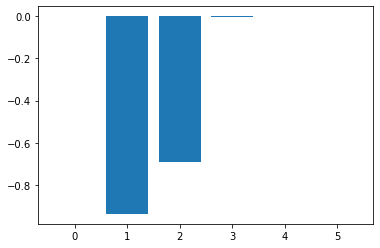

In [27]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

X, Y = features, target

# define the model # fit the model 
model = LinearRegression()
model.fit(X, Y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Logistic regression feature importance

Feature: 0, Score: -0.00000
Feature: 1, Score: 0.00066
Feature: 2, Score: -0.00021
Feature: 3, Score: -0.00014
Feature: 4, Score: 0.00031
Feature: 5, Score: -0.00095


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


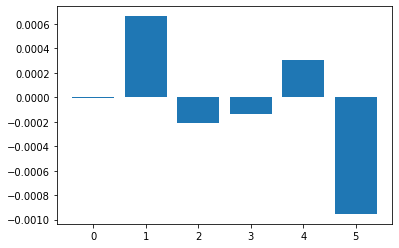

In [28]:
# logistic regression for feature importance 
from sklearn.datasets import make_classification 
from sklearn.linear_model import LogisticRegression 
import matplotlib.pyplot as plt

model = LogisticRegression()
model.fit(X, Y)
importance = model.coef_[0]

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))


plt.bar([x for x in range(len(importance))], importance) 
plt.show()

In [54]:
X

,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
0,143756,-119.02072,37.10931,8,2685,132
1,72297,-119.02044,37.14080,4,2646,135
2,-132,-119.02489,37.12035,16,2696,14
3,85167,-119.02189,37.12866,8,2645,82
4,143756,-119.02358,37.14074,9,2678,115
...,...,...,...,...,...,...
3536074,147671,-118.44985,36.10419,27,1761,273
3536075,68370,-118.43171,36.10711,31,1967,26
3536076,84581,-118.43883,36.10547,21,1790,308
3536077,132286,-118.43679,36.10559,35,1875,312


#### Decision tree feature importance - with regression

Feature: 0, Score: 0.02516
Feature: 1, Score: 0.33759
Feature: 2, Score: 0.32740
Feature: 3, Score: 0.04638
Feature: 4, Score: 0.17567
Feature: 5, Score: 0.08780


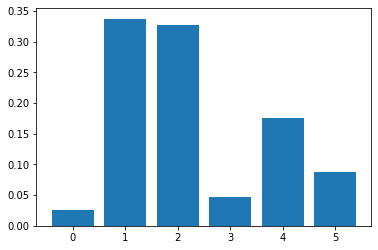

In [29]:
# from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
# define the model
model = DecisionTreeRegressor()
model.fit(X, Y) 
importance = model.feature_importances_ 

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Decision tree feature importance - with classifier

Feature: 0, Score: 0.05061
Feature: 1, Score: 0.28520
Feature: 2, Score: 0.30687
Feature: 3, Score: 0.07079
Feature: 4, Score: 0.16934
Feature: 5, Score: 0.11719


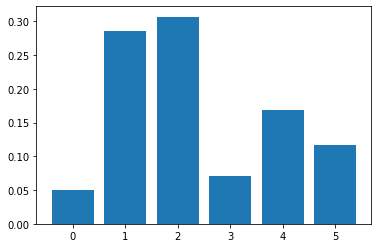

In [30]:
# from sklearn.datasets import make_classification 
from sklearn.tree import DecisionTreeClassifier 
import matplotlib.pyplot as plt

model = DecisionTreeClassifier()
model.fit(X, Y)
importance = model.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v)) 

plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Random forest feature importance - with regression

In [31]:
from sklearn.ensemble import RandomForestRegressor 

model = RandomForestRegressor()
model.fit(X, Y)
importance = model.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

KeyboardInterrupt: 

#### Random forest feature importance - with classification

In [ ]:
# random forest for feature importance on a regression problem 
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, Y)
importance = model.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v)) 

plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Spearman's Correlation

In [32]:
# Spearman's correlation is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables)
# It assesses how well the relationship between two variables can be described using a monotonic function

# change method to Spearman 
df_castle.corr(method='spearman')


,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
CARDBRECID,1.000000,0.300871,0.073949,0.669899,-0.959133,-0.223806,-0.057895,-0.093669
BURNSEVERITY2020BA4,0.300871,1.000000,0.068253,0.229382,-0.278050,-0.076468,0.073113,-0.084859
LEMMA_CODE,0.073949,0.068253,1.000000,0.009491,-0.081287,-0.120764,-0.055854,0.020260
LON,0.669899,0.229382,0.009491,1.000000,-0.452998,-0.138817,0.218228,-0.075289
LAT,-0.959133,-0.278050,-0.081287,-0.452998,1.000000,0.229527,0.128845,0.089381
SLOPE,-0.223806,-0.076468,-0.120764,-0.138817,0.229527,1.000000,-0.006908,0.104505
ELEV_M,-0.057895,0.073113,-0.055854,0.218228,0.128845,-0.006908,1.000000,-0.047470
ASPECT,-0.093669,-0.084859,0.020260,-0.075289,0.089381,0.104505,-0.047470,1.000000


In [33]:
df_creek.corr(method='spearman')

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
CARDBRECID,1.000000,0.187755,0.029160,-0.128184,-0.984876,0.053168,-0.402272,0.068223
BURNSEVERITY2020BA4,0.187755,1.000000,0.026739,-0.225867,-0.215045,0.126985,-0.331021,-0.010932
LEMMA_CODE,0.029160,0.026739,1.000000,-0.017271,-0.036877,-0.062832,-0.020824,0.055914
LON,-0.128184,-0.225867,-0.017271,1.000000,0.285486,-0.026700,0.545437,0.055092
LAT,-0.984876,-0.215045,-0.036877,0.285486,1.000000,-0.062704,0.479552,-0.058899
SLOPE,0.053168,0.126985,-0.062832,-0.026700,-0.062704,1.000000,-0.198093,0.130522
ELEV_M,-0.402272,-0.331021,-0.020824,0.545437,0.479552,-0.198093,1.000000,-0.024616
ASPECT,0.068223,-0.010932,0.055914,0.055092,-0.058899,0.130522,-0.024616,1.000000


In [34]:
df_claremont.corr(method='spearman')

,CARDBRECID,BURNSEVERITY2020BA4,LEMMA_CODE,LON,LAT,SLOPE,ELEV_M,ASPECT
CARDBRECID,1.000000,0.311894,-0.060440,-0.184492,-0.950594,-0.075180,-0.558847,0.058823
BURNSEVERITY2020BA4,0.311894,1.000000,-0.048161,-0.188397,-0.340430,-0.097886,-0.121140,0.028251
LEMMA_CODE,-0.060440,-0.048161,1.000000,0.082964,0.074867,-0.076156,0.107778,-0.012057
LON,-0.184492,-0.188397,0.082964,1.000000,0.451014,0.037230,0.529766,-0.053586
LAT,-0.950594,-0.340430,0.074867,0.451014,1.000000,0.091260,0.633743,-0.069066
SLOPE,-0.075180,-0.097886,-0.076156,0.037230,0.091260,1.000000,-0.276173,0.045884
ELEV_M,-0.558847,-0.121140,0.107778,0.529766,0.633743,-0.276173,1.000000,-0.031602
ASPECT,0.058823,0.028251,-0.012057,-0.053586,-0.069066,0.045884,-0.031602,1.000000


#### Verify Spearman Correlation with p-value
* [How to Calculate Nonparametric Rank Correlation in Python](https://machinelearningmastery.com/how-to-calculate-nonparametric-rank-correlation-in-python/)

In [35]:
x = df_castle[["BURNSEVERITY2020BA4"]]
x.astype('int16').dtypes
y = df_castle[["ELEV_M"]]

# scipy.stats.pearsonr(x.astype('int16').dtypes, y)  
# ValueError: x and y must have the same length. but checked x and y both has count of :1.666514e+06 
# x.describe()
# y.describe()

from scipy import stats
rho, pval = stats.spearmanr(x,y)

In [36]:
print('For Castle Fire Severity and Elevation\nSpearmans correlation coefficient: %.3f' % rho) 
# interpret the significance 
alpha = 0.05 
if pval > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % pval)
else:
    print('Samples are correlated (reject H0) p=%.3f' % pval)

For Castle Fire Severity and Elevation
Spearmans correlation coefficient: 0.073
Samples are correlated (reject H0) p=0.000


In [37]:
query = "SELECT BURNSEVERITY2020BA4, SLOPE, ELEV_M, ASPECT FROM PUBLIC.FIRE_SEVERITY WHERE FIRE_NAME = 'Castle'"
cur.execute(query)

df_castle_graph = cur.fetch_pandas_all() 

In [38]:
df_castle_graph

,BURNSEVERITY2020BA4,SLOPE,ELEV_M,ASPECT
0,2,29,1676,164
1,4,29,1571,135
2,2,36,1639,218
3,1,27,1603,180
4,2,37,1551,254
...,...,...,...,...
760839,1,38,2346,340
760840,1,8,2534,6
760841,1,19,2581,334
760842,1,31,2028,340


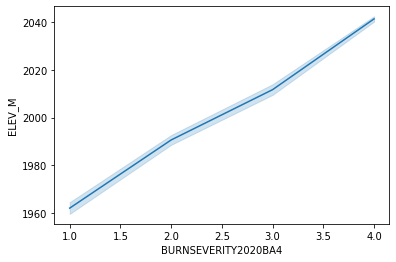

In [39]:
sns.lineplot(data=df_castle_graph, x="BURNSEVERITY2020BA4", y="ELEV_M")

In [40]:
# '''ValueError: 'RedBlue' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 
# 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 
# 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 
# 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 
# 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 
# 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 
# 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 
# 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
# '''

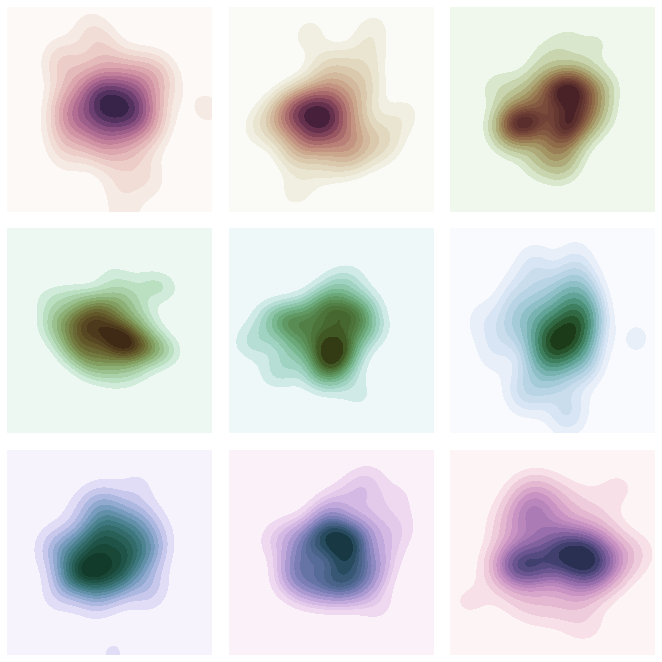

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
rs = np.random.RandomState(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rs.normal(size=(2, 50))
    sns.kdeplot(
        x=x, y=y,
        cmap=cmap, fill=True,
        clip=(-5, 5), cut=10,
        thresh=0, levels=15,
        ax=ax,
    )
    ax.set_axis_off()

ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))
f.subplots_adjust(0, 0, 1, 1, .08, .08)

ValueError: Contour levels must be increasing

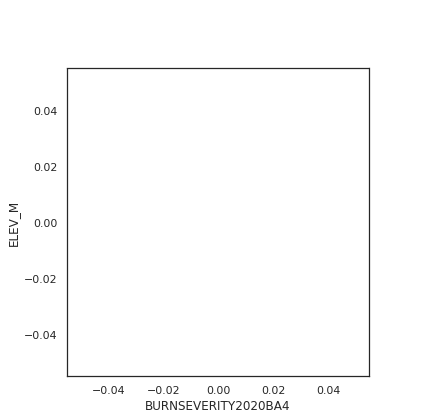

In [59]:
import seaborn as sns
sns.set_theme(style="white")

# df = sns.load_dataset("penguins")

g = sns.JointGrid(data=df_castle_graph, x="BURNSEVERITY2020BA4", y="ELEV_M", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((2200, 6800), (10, 25)),
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

ValueError: Contour levels must be increasing

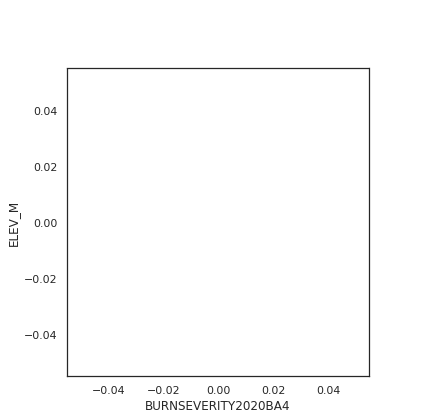

In [58]:
import seaborn as sns
sns.set_theme(style="white")

# df = sns.load_dataset("penguins")

g = sns.JointGrid(data=df_castle_graph, x="BURNSEVERITY2020BA4", y="ELEV_M", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((2200, 6800), (10, 25)),
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

#### df_castle coorelation matrix

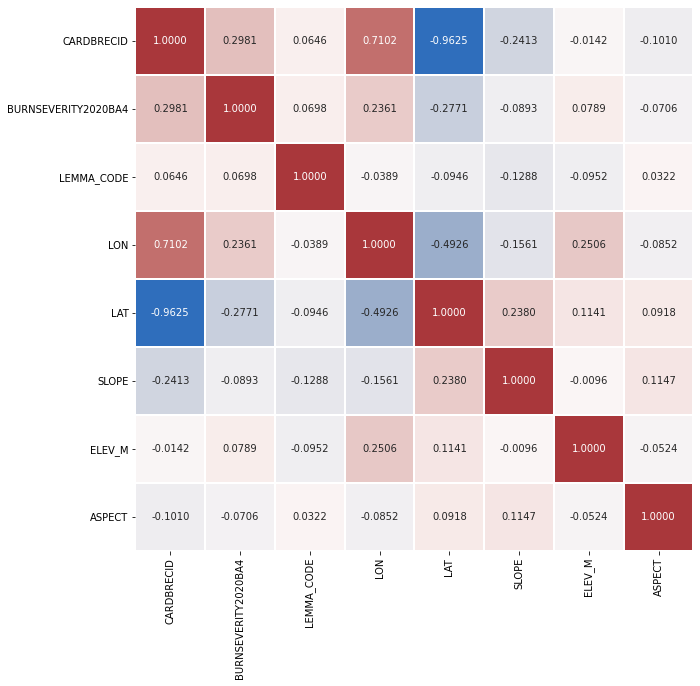

In [44]:
plt.rc('figure', figsize=(10,10))
corrMatrix = df_castle.corr()
ax = sns.heatmap(corrMatrix, annot=True, cmap="vlag", linewidths=1, cbar=False, center=0,fmt=".4f") 

plt.show()

#### df_creek coorelation matrix

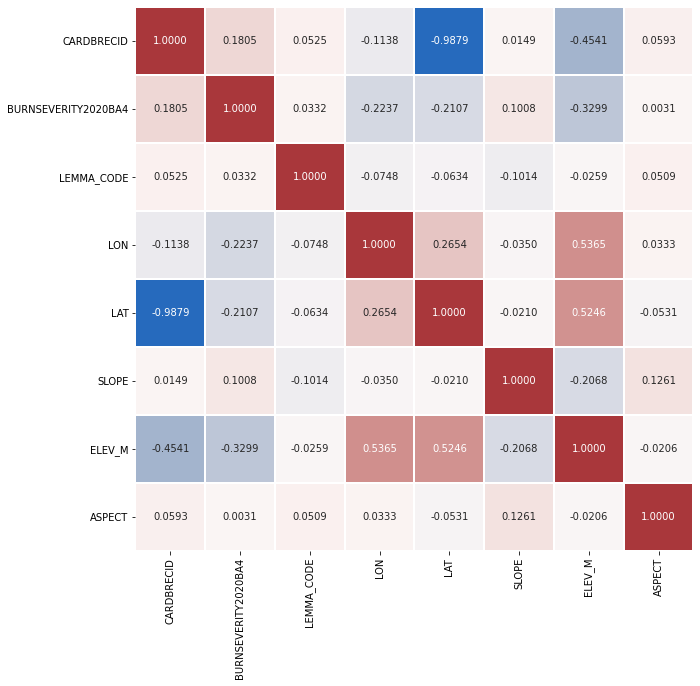

In [45]:
plt.rc('figure', figsize=(10,10))
corrMatrix = df_creek.corr()
ax = sns.heatmap(corrMatrix, annot=True, cmap="vlag", linewidths=1, cbar=False, center=0,fmt=".4f") 

plt.show()

#### df_claremont coorelation matrix

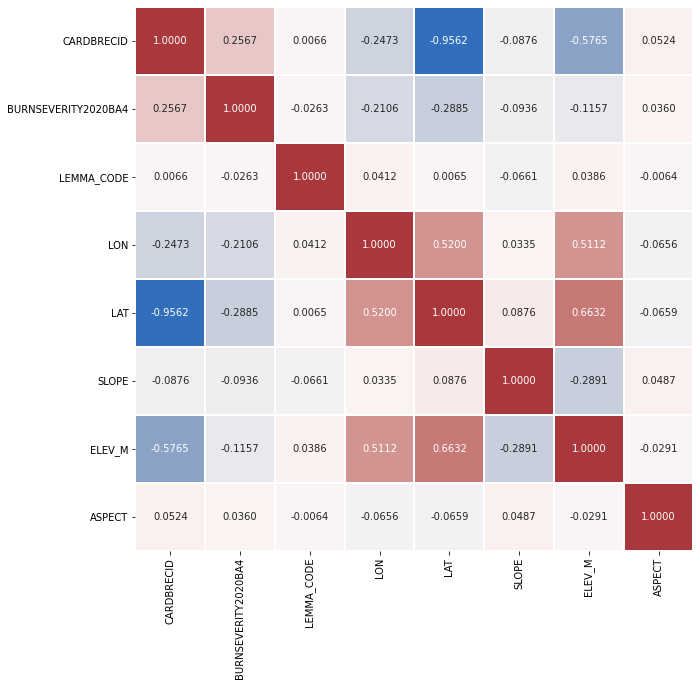

In [46]:
plt.rc('figure', figsize=(10,10))
corrMatrix = df_claremont.corr()
ax = sns.heatmap(corrMatrix, annot=True, cmap="vlag", linewidths=1, cbar=False, center=0,fmt=".4f") 

plt.show()

#### Modeling
##### [Ordinal logistic regression](https://rikunert.com/ordinal_rating)

In [47]:
# linear-regression vs logistic-regression 
from sklearn.linear_model import LinearRegression, LogisticRegression 
from mord import LogisticAT  

# Build models

model_linear = LinearRegression()
model_ovr = LogisticRegression(multi_class='ovr', class_weight='balanced')
model_mul = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
# alpha set to zero - to perform no regularisation
model_ordinal = LogisticAT(alpha=0)  


In [48]:
# /opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning. FutureWarning) 
#https://stackoverflow.com/questions/52640386/how-do-i-solve-the-future-warning-min-groups-self-n-splits-warning-in 
# import warnings warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer


# divide df_regression into features matrix and target vector
features = df_regression.iloc[:, 1:]
target = df_regression['BURNSEVERITY2020BA4']

##### Mean Absolute Error

In [49]:
# Mean Absolute Error
MAE = make_scorer(mean_absolute_error)

##### MAE on Linear regression

In [50]:
# MAE on Linear regression

MAE_linear = cross_val_score(model_linear, features, target, cv=5, scoring=MAE)
np.mean(MAE_linear)
# 1.0571568406289982

1.0571568406289982

##### MAE on Logistic regression - one versus rest

In [51]:
# MAE on Logistic regression - one versus rest

MAE_ovr = cross_val_score(model_ovr, features, target, cv=5, scoring=MAE)
np.mean(MAE_ovr)
# 1.2318457409558428

1.2318457409558428

##### MAE on Logistic regression - multinomial

In [52]:
# MAE on Logistic regression - multinomial

MAE_mul = cross_val_score(model_mul, features, target, cv=5, scoring=MAE)
np.mean(MAE_mul)
# 1.2802188260119192

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


1.2802188260119192

##### MAE on Ordered logistic regression

In [53]:
# MAE on Ordered logistic regression

MAE_ordinal = cross_val_score(model_ordinal, features, target, cv=5, scoring=MAE)
np.mean(MAE_ordinal)

KeyboardInterrupt: 

#### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score  

def get_accuracy_score(target_true, target_fit):
    target_fit = np.round(target_fit)
    target_fit.astype('int')
    return accuracy_score(target_true, target_fit)

acc = make_scorer(get_accuracy_score)

#### Linear regression accuracy

In [ ]:
# Linear regression Accuracy
cc_linear = cross_val_score(model_linear, features, target, cv=5, scoring=acc)
np.mean(acc_linear))

#### Logistic regression (one versus rest) accuracy

In [ ]:
# Logistic regression (one versus rest)
acc_ovr = cross_val_score(model_ovr, features, target, cv=5, scoring=acc)
np.mean(acc_ovr)

#### Logistic regression (multinomial) accuracy

In [ ]:
# Logistic regression (multinomial)
acc_multi = cross_val_score(model_mul, features, target, cv=5, scoring=acc)
np.mean(acc_multi)

#### Ordered logistic regression accuracy

In [ ]:
# Ordered logistic regression
acc_ordinal = cross_val_score(model_ordinal, features, target, cv=5, scoring=acc)
np.mean(acc_ordinal)

In [ ]:
# 0.14964767652817043 
# 0.3765488273342543 

#### [Decision Tree](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)
* [Understanding decision tree classification with scikit learn](https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd)

In [60]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics, tree

In [61]:
labels = df['EVT_FUEL_N'].astype('category').cat.categories.tolist()
replace_evt = {'EVT_FUEL_N' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
replace_evt

KeyError: 'EVT_FUEL_N'

In [62]:
df_replace = df.copy()
df_replace.replace(replace_evt, inplace=True)
df_replace.head()

NameError: name 'replace_evt' is not defined

In [63]:
df_replace['EVT_FUEL_N'].dtypes

KeyError: 'EVT_FUEL_N'

In [ ]:
# feature
feature_cols = ['EVT_FUEL_N','LEMMA_CODE','SLOPE', 'ELEV_M','ASPECT']
X = df_replace[feature_cols]  
# target
Y = df_replace.BURNSEVERITY2020BA4

In [ ]:
# 70% training and 30% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [ ]:
# Create Decision Tree classifer object & train Decision Tree Classifer 
dtc = DecisionTreeClassifier()
dtc = dtc.fit(X_train,Y_train)

#Predict the response for test dataset
Y_pred = dtc.predict(X_test)

In [ ]:
# Model Accuracy = TP/(TP+FP+TN+FN)
metrics.accuracy_score(Y_test, Y_pred)

In [ ]:
# Confusion Matrix
severity = np.array(Y_test)
predictions = np.array(Y_pred)

confusion_matrix = metrics.confusion_matrix(severity, predictions)
confusion_matrix

In [ ]:
tree.plot_tree(dtc)

#  Ran over 2 hours....

In [ ]:
# Decision tree classifer - 2
dtc2 = DecisionTreeClassifier(max_depth=6)
# Train Decision Tree Classifer
dtc2 = dtc2.fit(X_train, Y_train)
# Predict the response for test dataset
Y_pred2 = dtc2.predict(X_test)

# Model2 Accuracy
metrics.accuracy_score(Y_test, Y_pred2)

In [ ]:
tree.plot_tree(dtc2)

In [ ]:
# Decision tree classifer 3
dtc3 = DecisionTreeClassifier(max_depth=6)  
# Train Decision Tree Classifer 
dtc3 = dtc3.fit(X_train, Y_train)  
# Predict the response for test dataset 
Y_pred3 = dtc3.predict(X_test)  

# Model3 Accuracy
metrics.accuracy_score(Y_test, Y_pred2)

In [ ]:
tree.plot_tree(dtc3)

#### Visualize decision tree 1
* [Decision tree in Python](https://towardsdatascience.com/decision-tree-in-python-b433ae57fb93)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data

dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data, feature_names=feature_cols)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

#### Hot spot analysis (Still having trouble in this part)
* [Ref1](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/hot-spot-analysis.htm)
* [Ref2](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/hot-spot-analysis.htm#GUID-962A2207-58C5-4D3A-AD16-A8588AB5692E)

In [ ]:
# can try other encoding for EVT_FUEL_N and see if accuracy improves (https://www.kaggle.com/gabrielaltay/categorical-variables-in-decision-trees)
# but based on my memory, I remember along the lines of regression provides a good baseline. If so, logistic regression also shows 45% so that may be the range with these attributes
# so perhaps need to add other datasets to see
# can try to evaluate the model # https://www.datacamp.com/community/tutorials/decision-tree-classification-python
#interesting link https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd

#for hotspot
import os
import json
import shutil
import seaborn as sns

# import pandas as pd
# import numpy as np

import zipfile
from zipfile import ZipFile

import arcgis
from arcgis.gis import GIS
from arcgis.mapping import WebMap, WebScene
from arcgis.features import FeatureLayer
from arcgis.features import GeoAccessor, GeoSeriesAccessor

import arcpy 
from arcpy import env

from IPython.display import display
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt


In [ ]:
sdf = pd.DataFrame.spatial.from_xy(df, x_column = 'LON', y_column = 'LAT', sr=4326)
sdf.head()

#### for ArcGIS Online:
* [create a geodatabase](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/create-file-gdb.htm#C_GUID-DB1C0BE8-EE77-4253-A7D2-7CCC5F803A7C):
* /arcgis/home/hotspot/df_hotspot.gdb

In [ ]:
# Create a folder and a file geodatabase
# https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/create-file-gdb.htm#C_GUID-DB1C0BE8-EE77-4253-A7D2-7CCC5F803A7C
os.mkdir('/arcgis/home/hotspot')
arcpy.CreateFileGDB_management('/arcgis/home/hotspot', 'df_hotspot.gdb')

In [ ]:
# create a new feature class "san_diego_airbnb_listings_for_analysis" and add it to our geodatabase
sdf.spatial.to_featureclass(location=r'/arcgis/home/hotspot/df_hotspot.gdb/sdf_hotspot_analysis')

In [ ]:
# check data exist
file_geodatabase = env.workspace = ('/arcgis/home/hotspot/df_hotspot.gdb')
list_features = arcpy.ListFeatureClasses()
list_features

In [ ]:
# Set the path to the "san_diego_airbnb_listings" data
df_hotspot_data = file_geodatabase + '/sdf_hotspot_analysis'

In [ ]:
sdf_data_prj = file_geodatabase + '/sdf_hotspot_analysis'
sdf_fire_HS1 = arcpy.stats.HotSpots(sdf_data_prj,"BURNSEVERITY2020BA4", "{0}//{1}".format(file_geodatabase,"sdf_fire_HS1"), 
for i in range(0, sdf_fire_HS1.messageCount):
    print(sdf_fire_HS1.getMessage(i))

In [ ]:
sdf_fire_HS1.getOutput(0)

In [ ]:
file_geodatabase = env.workspace = ('/arcgis/home/hotspot/df_hotspot.gdb')
sdf2 = pd.DataFrame.spatial.from_featureclass(file_geodatabase + '/sdf_fire_HS1')
sdf2.head()

In [ ]:
sdf2.describe().T

In [ ]:
m1 = GIS().map("California")
m1.zoom = 8
m1.center = [37.577200, -120.7470000]
sdf2.spatial.plot(
    map_widget = m1,
    renderer_type = 'c',  # for class breaks renderer
    class_count = 7,  # choose the number of classes
    col = 'Gi_Bin',  # numeric column to classify
    cmap = 'bwr',  # color map to pick colors from for each class
    alpha = 0.7  # specify opacity
)

m1.legend = True
m1

In [ ]:
# publish to feature layer instead

import time
current_date_time = time.strftime("%Y%m%d-%H%M%S")
layer_name = 'sdf_fire_HS1'+ str(current_date_time)

lyr = sdf2.spatial.to_featurelayer(layer_name)
lyr

#### Run Clustering Analysis
##### DBSCAN
* [Reference 1](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm)
* [Reference 2](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm#GUID-B146C426-4E83-45ED-B6BF-F94586223C31)

In [ ]:
# arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster, {search_distance}, cluster_sensitivity)

in_features = df_hotspot_data
output_features = file_geodatabase + '/DBSCAN_v1'
cluster_method = "DBSCAN"
min_features_cluster = 20
# search_distance = 
# cluster_sensitivity = 

arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster)

In [ ]:
sdf1 = pd.DataFrame.spatial.from_featureclass(file_geodatabase + '/DBSCAN_v1') sdf1.head()
sdf1.head()

In [ ]:
sdf1.describe().T

In [ ]:
# publish to feature layer

import time
current_date_time = time.strftime("%Y%m%d-%H%M%S")
layer_name = 'sdf_fire_DBSCAN'+ str(current_date_time)

lyr = sdf1.spatial.to_featurelayer(layer_name)
lyr

##### [HDBSCAN](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm)
* [REF1](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm)
* [REF2](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm#GUID-B146C426-4E83-45ED-B6BF-F94586223C31)

In [65]:
in_features = df_hotspot_data
output_features = file_geodatabase + '/HDBSCAN_v1'
cluster_method = "HDBSCAN"
min_features_cluster = 20
# search_distance = 
# cluster_sensitivity = 

arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster)

NameError: name 'df_hotspot_data' is not defined

In [ ]:
sdf2 = pd.DataFrame.spatial.from_featureclass(file_geodatabase + '/HDBSCAN_v1')
sdf2.head()

In [ ]:
sdf2.describe().T

In [ ]:
m2 = GIS().map("California")
m2.zoom = 8
m2.center = [39,-117] sdf2.spatial.plot(
    map_widget = m2, 
    renderer_type = 'u',  # for unique breaks renderer
    method ='esriClassifyManual',
    # standardDeviationInterval = 1,
    # # class_count = 7,  # choose the number of classes
    col = 'COLOR_ID',  # numeric column to classify
    cmap = 'gist_ncar',  # color map to pick colors from for each class
    alpha = 0.5,  # specify opacity
    outline_color='binary',
    marker_size = 6,
    line_width = 1
)

m2.legend = True
m2

In [ ]:
# publish to feature layer
# import time
current_date_time = time.strftime("%Y%m%d-%H%M%S")
layer_name = 'sdf_fire_HDBSCAN'+ str(current_date_time)

lyr = sdf1.spatial.to_featurelayer(layer_name)
lyr

#### OPTICS
* [REF1](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm)
* [REF2](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/densitybasedclustering.htm#GUID-B146C426-4E83-45ED-B6BF-F94586223C31)

In [ ]:
# arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster, {search_distance}, cluster_sensitivity)

in_features = df_hotspot_data
output/_features = file_geodatabase + '/OPTICS_v1' cluster_method = "OPTICS"
min_features_cluster = 20 
# search_distance =  
# cluster_sensitivity =

arcpy.stats.DensityBasedClustering(in_features, output_features, cluster_method, min_features_cluster)

In [ ]:
sdf3 = pd.DataFrame.spatial.from_featureclass(file_geodatabase + '/OPTICS_v1')
sdf3.head()

In [ ]:
sdf3.describe().T

In [ ]:
m3 = GIS().map("California")
m3.zoom = 8
m3.center = [39,-117]
sdf3.spatial.plot(
    map_widget = m3,
    renderer_type = 'u',  # for unique breaks renderer
    method ='esriClassifyManual',
    # standardDeviationInterval = 1,
    class_count = 5,
    col = 'COLOR_ID',
    cmap = 'gist_ncar',
    alpha = 0.7,  # specify opacity
    outline_color='binary',
    marker_size = 8,
    line_width = 0.5
)
m3.legend = True
m3

In [ ]:
# publish to feature layer 
import time
current_date_time = time.strftime("%Y%m%d-%H%M%S")
layer_name = 'sdf_fire_OPTICS'+ str(current_date_time)
lyr = sdf1.spatial.to_featurelayer(layer_name)
lyr

#### Deployment / Conclusion